In [2]:
#!pip install pytorch_lightning

In [1]:
#!pip install torch

In [ ]:
import argparse
import math
import random
import re
from collections import Counter
from dataclasses import dataclass
from typing import List,Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2TokenizerFast
from datasets import load_dataset
from sklearn.metrics import f1_score, accuracy_score
from torchmetrics import Accuracy, F1Score, Precision, Perplexity

## **1.Model_Components**

##### **SelfAttention**

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, n_embd: int, seq_len: int, attn_pdrop: float= 0.0, resid_pdrop: float= 0.0):
    super().__init__(self)
    self.key = nn.Linear(n_embd, n_embd, bias= False)
    self.query = nn.Linear(n_embd, n_embd, bias= False)
    self.value = nn.Linear(n_embd, n_embd, bias=False)
    self.attn_drop = nn.Dropout(attn_pdrop)
    self.resid_drop = nn.Dropout(resid_pdrop)
    self.register_buffer('mask',torch.tril(torch.ones(seq_len,seq_len)).view(1,1,seq_len,seq_len))
    self.n_embd = n_embd

  def forward(self,x):
    B,T,C = x.size()
    k = self.key(x)
    q = self.query(x)
    v = self.value(x)
    att = (q @ k.transpose(-2,-1)) / math.sqrt(C)
    att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
    att = F.softmax(att,dim=-1)
    att = self.attn_drop(att)
    y = att @ v
    y = self.resid_drop(y)
    return y

##### **MultiHeadAttention**

SelfAttention & MultiHeadAttention ▶


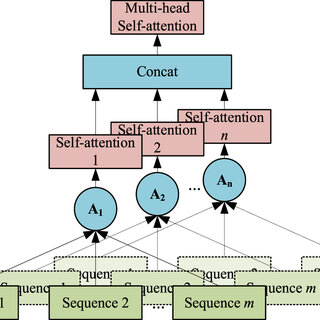

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self,n_embd:int,n_head:int,seq_len:int,attn_pdrop:float=0.0,resid_pdrop:float=0.0):
    super().__init__()
    assert n_embd % n_head == 0
    self.n_head = n_head
    self.head_dim = n_embd // n_head
    # concatenated attention weights : (B, T, n_embd) -> (B, T, 3 * n_embd)
    self.c_attn = nn.Linear(n_embd, 3 * n_embd, bias = False)
    self.out_proj = nn.Linear(n_embd, n_embd, bias = False)
    self.attn_drop = nn.Dropout(attn_pdrop)
    self.resid_drop = nn.Dropout(resid_pdrop)
    self.register_buffer('mask',torch.tril(torch.ones(seq_len,seq_len)).view(1,1,seq_len,seq_len))

  def forward(self,x):
    B,T,C = x.shape
    qkv = self.c_attn(x)   # Concat
    q,k,v = qkv.split(C, dim = 2)  # dim = 2 -> تقسیم میشود C بعد سوم به تکه هایی به اندازه
    q = q.view(B,T,self.n_head, C // self.n_head).transpose(1,2)
    k = k.view(B,T,self.n_head, C // self.n_head).transpose(1,2)
    v = v.view(B,T,self.n_head, C // self.n_head).transpose(1,2)
    att = (q @ k.transpose(-2,-1)) / math.sqrt(C//self.n_head)
    att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
    att = F.softmax(att, dim = -1)
    att = self.attn_drop(att)
    y = att @ v
    y = y.transpose(1,2).contiguous().view(B,T,C)
    y = self.resid_drop(self.out_proj(y))
    return y

##### **TransformerBlock**

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, n_embd: int, n_head: int, seq_len: int, mlp_ratio = 4.0, attn_pdrop=0.0, resid_pdrop=0.0):
    super().__init__()
    self.ln1 = nn.LayerNorm(n_embd)
    self.attn = MultiHeadAttention(n_embd,n_head,seq_len,attn_pdrop,resid_pdrop)
    self.ln2 = nn.LayerNorm(n_embd)
    self.mlp = nn.Sequential(
        nn.Linear(n_embd,int(mlp_ratio * n_embd)),
        nn.GELU(),
        nn.Linear(int(mlp_ratio * n_embd) ,n_embd),
        nn.Dropout(resid_pdrop)
    )

  def forward(self,x):
    x = x + self.attn(self.ln1(x))
    x = x + self.mlp(self.ln2(x))
    return x

##### **ConvBlock**

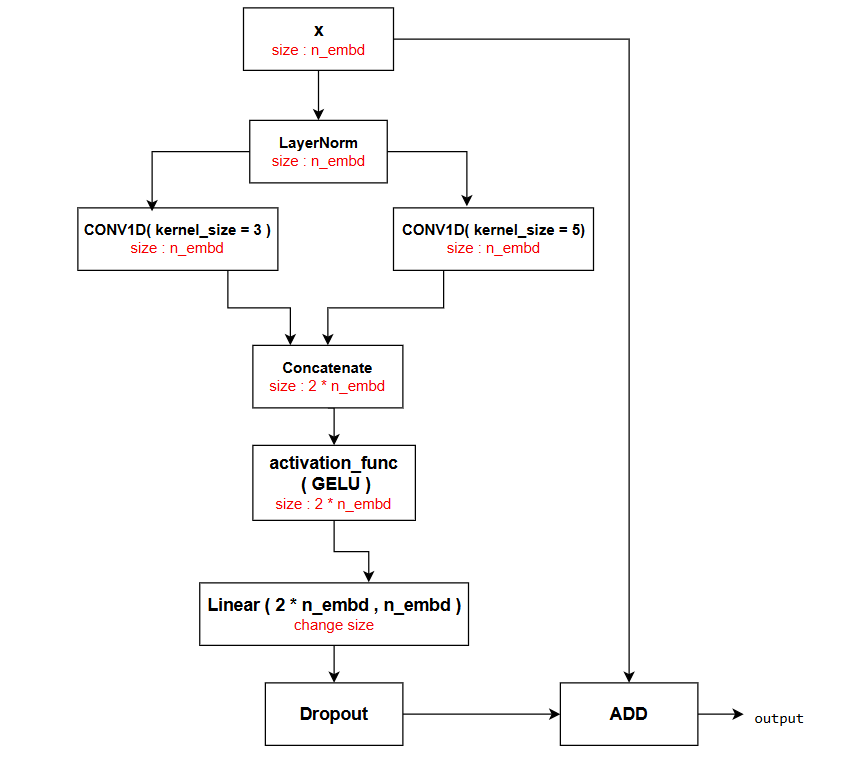

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, n_embd: int, pdrop= 0.0):
    super().__init__()
    self.ln = nn.LayerNorm(n_embd)
    self.conv3 = nn.Conv1d(n_embd,n_embd,kernel_size=3,padding=1,groups=1)
    self.conv5 = nn.Conv1d(n_embd,n_embd,kernel_size=5,padding=2,groups=1)
    self.proj = nn.Linear(2*n_embd,n_embd)
    self.drop = nn.Dropout(pdrop)
    self.act = nn.GELU()

  def forward(self,x):
    B,T,C = x.shape
    h = self.ln(x)
    h = h.transpose(1,2)
    y3 = self.conv3(h)
    y5 = self.conv5(h)
    y = torch.cat([y3,y5],dim=1).transpose(1,2)
    y = self.proj(self.act(y))
    y = self.drop(y)
    return x + y

##### **MLPBlock**

x ➡ LayerNorm ➡ Linear ➡ GELU ➡ Linear ➡ Dropout ➡ y

x + y ➡ OUTPUT


In [ ]:
class MLPBlock(nn.Module):
  def __init__(self,n_embd:int,mlp_ratio=4.0,pdrop=0.0):
    super().__init__()
    self.ln = nn.LayerNorm(n_embd)
    self.fc1 = nn.Linear(n_embd,int(mlp_ratio * n_embd))
    self.fc2 = nn.Linear(int(mlp_ratio * n_embd),n_embd)
    self.drop = nn.Dropout(pdrop)
    self.act = nn.GELU()

  def forward(self,x):
    h = self.ln(x)
    h = self.fc2(self.act(self.fc1(h)))
    h = self.drop(h)
    return x+h

##### **MODEL**

**self.apply(self._init_weights)** :    مقدار دهی اولیه وزنهای مدل

وزن های مدل استفاده میشه initialize برای self.apply(self._init_weights)

initialize : مقداردهی اولیه

توضیحات ▶

apply(fn) :
را روی تمام زیر ماژول های ماژول مفروض  اعمال میکند fn این کد متد

self.apply(self._init_weights) ➡
روی تمام لایه های شبکه اعمال میشود_init_weights یعنی تابع

علت استفاده ▶

مقداردهی اولیه وزن‌ها خیلی مهمه

اگه وزن‌ها بد مقداردهی اولیه بشن ⬅ شبکه به سختی یاد می‌گیره یا ممکنه گرادیان‌ها منفجر/ناپدید بشن

با مقداردهی درست، آموزش مدل سریع‌تر و پایدارتر میشه


خلاصه self.apply(self._init_weights) یعنی ▶

برو تمام لایه‌های مدل رو پیدا کن و برای هرکدوم روش تابع مقداردهی اولیه وزن‌ها رو اجرا کن


In [ ]:
class HybridLM(nn.Module):
  def __init__(self, vocab_size:int, seq_len:int, n_layer:int, n_head:int, n_embd:int, attn_pdrop=0.0, resid_pdrop=0.0):
    super().__init__()
    assert n_layer == 10, "This script assumes 10 total layers in a fixed hybrid plan"
    self.seq_len = seq_len
    self.tok_emb = nn.Embedding(vocab_size, n_embd) # Added n_embd here
    self.pos_emb = nn.Parameter(torch.zeros(1,seq_len,n_embd))
    self.drop = nn.Dropout(resid_pdrop)
    self.layers = nn.ModuleList([
        ConvBlock(n_embd,pdrop=resid_pdrop), # 1, changed dropout to pdrop
        ConvBlock(n_embd,pdrop=resid_pdrop), # 2, changed dropout to pdrop
        TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 3
        TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 4
        TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 5
        TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 6
        TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 7
        MLPBlock(n_embd,mlp_ratio=4.0,pdrop=resid_pdrop), # 8, changed dropout to pdrop
        MLPBlock(n_embd,mlp_ratio=4.0,pdrop=resid_pdrop), # 9, changed dropout to pdrop
        TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop) # 10
    ])
    self.ln_f = nn.LayerNorm(n_embd)
    self.head = nn.Linear(n_embd,vocab_size,bias=False)
    self.apply(self._init_weights)

  def _init_weights(self,m):
    if isinstance(m,nn.Linear):
      nn.init.normal_(m.weight,mean=0.0,std=0.02)
      if m.bias is not None: nn.init.zeros_(m.bias)
    elif isinstance(m,nn.Embedding):
      nn.init.normal_(m.weight,mean=0.0,std=0.02)

  def forward(self,idx,targets=None):
    B,T = idx.size()
    assert T <= self.seq_len
    x = self.tok_emb(idx) + self.pos_emb[:,:T,:]
    x = self.drop(x)
    for layer in self.layers:
      x = layer(x)
    x = self.ln_f(x)
    logits = self.head(x)
    loss = None
    if targets is not None:
      loss = F.cross_entropy(logits.view(-1,logits.size(-1)),targets.view(-1))
    return logits,loss

  @torch.no_grad()
  def generate(self,idx,max_new_tokens=100,temperature=1.0,top_k=None):
    for _ in range(max_new_tokens):
      idx_cond = idx[:,-self.seq_len:]
      logits,_ = self(idx_cond)
      logits = logits[:,-1,:] / max(1e-8,temperature) # Corrected temperature variable name
      if top_k is not None :
        v,_ = torch.topk(logits,top_k)
        logits[logits < v[:,[-1]]] = -float('Inf')
      probs = F.softmax(logits,dim=-1)
      next_id = torch.multinomial(probs,num_samples=1)
      idx = torch.cat((idx,next_id),dim=1)
    return idx

## **2.Dataset-Wrapper**

In [ ]:
class TokenDataset(Dataset):
  def __init__(self,data_ids,seq_len):
    self.data = data_ids
    self.seq_len = seq_len

  def __len__(self):
    return len(self.data) // self.seq_len

  def __getitem__(self,idx):
    start = idx * self.seq_len
    x = self.data[start : start + self.seq_len]
    y = self.data[start + 1 : start + self.seq_len + 1]
    return x, y # Corrected to return x and y separately

## **3.Lightning-Module**

In [ ]:
class LitHybridLM(pl.LightningModule):
  def __init__(self,vocab_size,seq_len=256,num_classes=4,n_layer=10,n_head=6,n_embd=384,lr=3e-4):
    super().__init__()
    self.save_hyperparameters()
    self.model = HybridLM(vocab_size, seq_len, n_layer, n_head, n_embd)
    self.lr = lr
    self.perplexity = Perplexity(ignore_index=-100)

  def training_step(self, batch, batch_idx):
    x, y = batch
    logits, loss = self.model(x,y)
    self.log("train_loss", loss, prog_bar=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x,y = batch
    logits,loss = self.model(x,y)
    ppl = self.perplexity(logits,y)

    self.log("val_loss",loss,prog_bar=True)
    self.log("val_perplexity",ppl)

  def configure_optimizers(self):
    return torch.optim.AdamW(self.parameters(),lr=self.lr)

In [ ]:
class LitHybridLM_Models(pl.LightningModule):
  def __init__(self,ModelClass,vocab_size,seq_len=256,num_classes=4,n_layer=10,n_head=6,n_embd=384,lr=3e-4):
    super().__init__()
    self.save_hyperparameters()
    self.model = ModelClass(vocab_size, seq_len, n_layer, n_head, n_embd)
    self.lr = lr
    self.perplexity = Perplexity(ignore_index=-100)

  def training_step(self, batch, batch_idx):
    x, y = batch
    logits, loss = self.model(x,y)
    self.log("train_loss", loss, prog_bar=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x,y = batch
    logits,loss = self.model(x,y)
    ppl = self.perplexity(logits,y)

    self.log("val_loss",loss,prog_bar=True)
    self.log("val_perplexity",ppl)

  def configure_optimizers(self):
    return torch.optim.AdamW(self.parameters(),lr=self.lr)

## **4. Load Dataset & Tokenizer**

In [ ]:
dataset = load_dataset("ag_news")

tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

## **5.Utiliteis**

In [ ]:
def encode_texts(texts):
  enc = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
  return enc["input_ids"].view(-1)

In [ ]:
def data_loader(train_size:int,val_size:int,seq_len:int = 256 , batch_size:int=24):
  train_texts = dataset["train"]["text"][:train_size]
  val_texts = dataset["test"]["text"][:val_size]

  train_ids = encode_texts(train_texts)
  val_ids = encode_texts(val_texts)

  #seq_len = 256
  #batch_size = 24
  train_ds = TokenDataset(train_ids, seq_len = seq_len)
  val_ds = TokenDataset(val_ids, seq_len = seq_len)

  train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_ds, batch_size=batch_size)

  return train_loader,val_loader

In [ ]:
def train_method(ModelClass,train_size:int,val_size:int,n_layer:int,seq_len:int=256,batch_size:int = 24):
  train_loader,val_loader = data_loader(train_size,val_size,seq_len,batch_size)

  lit_model = LitHybridLM_Models(ModelClass= ModelClass,vocab_size=len(tokenizer),n_layer=n_layer)

  trainer = pl.Trainer(
      max_epochs=3,
      accelerator="auto",
      devices=1,
      precision=16,
      log_every_n_steps=10
  )

  trainer.fit(lit_model, train_loader, val_loader)
  return trainer

## **6.Train**


In [ ]:
trainer = train_method(ModelClass= HybridLM,train_size=10000,val_size=2900,n_layer=10)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | model      | HybridLM    | 54.7 M | train
1 | perplexity | _Perplexity | 0      | train
---------------------------------------------------
54.7 M    Trainable params
0         Non-traina

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
val_perp = trainer.callback_metrics["val_perplexity"].item()
val_loss = trainer.callback_metrics["val_loss"].item()
print(f"Validation Loss : {val_loss:.4f} | Perplexity : {val_perp:.2f}")

Validation Loss : 0.0961 | Perplexity : 1.10


**ارزیابی** ▶

پرپلکسیتی کم ▶

یعنی مدل تقریبا خیلی مطمئن در پیش بینی توکن بعدی است

پرپلکسیتی معمولی روی دیتاست های واقعی معمولا بالاتر از 20 یا حتی 50 میشود, مگر اینکه **دیتاست خیلی ساده** یا **مدل خیلی بزرگ** باشد

اینکه پرپلکسیتی الان کم شده به دو دلیل میتونه باشه ▶

1. دیتاستی که مدل را باهاش آموزش دادیم خیلی ساده یا تکراری است,(که البته همینطوره, 5000 نمونه خیلی کمه )

2. مدل روی داده خیلی خوب فیت شده(اورفیتینگ) , که البته احتمالا همینطوره , چون مدل 10 لایه با دیتاست خیلی کوچک آموزشی داریم

## **7.Labratory(1)**

Dataset : "ag_news"

Changing the model architecture

Changing train_size and val_size

### **Train(2)**

model ( 5 Layers ) : ConvBlock -> TransformerBlock ( * 3 ) -> MLPBlock

train_size : 7000

val_size : 1800

In [ ]:
class HybridLM_2(nn.Module):
  def __init__(self, vocab_size:int, seq_len:int, n_layer:int, n_head:int, n_embd:int, attn_pdrop=0.0, resid_pdrop=0.0):
    super().__init__()
    assert n_layer == 5, "This script assumes 5 total layers in a fixed hybrid plan"
    self.seq_len = seq_len
    self.tok_emb = nn.Embedding(vocab_size, n_embd) # Added n_embd here
    self.pos_emb = nn.Parameter(torch.zeros(1,seq_len,n_embd))
    self.drop = nn.Dropout(resid_pdrop)
    self.layers = nn.ModuleList([
      #  ConvBlock(n_embd,pdrop=resid_pdrop), # 1, changed dropout to pdrop
        ConvBlock(n_embd,pdrop=resid_pdrop), # 2, changed dropout to pdrop
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 3
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 4
        TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 5
        TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 6
        TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 7
     #   MLPBlock(n_embd,mlp_ratio=4.0,pdrop=resid_pdrop), # 8, changed dropout to pdrop
        MLPBlock(n_embd,mlp_ratio=4.0,pdrop=resid_pdrop), # 9, changed dropout to pdrop
     #   TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop) # 10
    ])
    self.ln_f = nn.LayerNorm(n_embd)
    self.head = nn.Linear(n_embd,vocab_size,bias=False)
    self.apply(self._init_weights)

  def _init_weights(self,m):
    if isinstance(m,nn.Linear):
      nn.init.normal_(m.weight,mean=0.0,std=0.02)
      if m.bias is not None: nn.init.zeros_(m.bias)
    elif isinstance(m,nn.Embedding):
      nn.init.normal_(m.weight,mean=0.0,std=0.02)

  def forward(self,idx,targets=None):
    B,T = idx.size()
    assert T <= self.seq_len
    x = self.tok_emb(idx) + self.pos_emb[:,:T,:]
    x = self.drop(x)
    for layer in self.layers:
      x = layer(x)
    x = self.ln_f(x)
    logits = self.head(x)
    loss = None
    if targets is not None:
      loss = F.cross_entropy(logits.view(-1,logits.size(-1)),targets.view(-1))
    return logits,loss

  @torch.no_grad()
  def generate(self,idx,max_new_tokens=100,temperature=1.0,top_k=None):
    for _ in range(max_new_tokens):
      idx_cond = idx[:,-self.seq_len:]
      logits,_ = self(idx_cond)
      logits = logits[:,-1,:] / max(1e-8,temperature) # Corrected temperature variable name
      if top_k is not None :
        v,_ = torch.topk(logits,top_k)
        logits[logits < v[:,[-1]]] = -float('Inf')
      probs = F.softmax(logits,dim=-1)
      next_id = torch.multinomial(probs,num_samples=1)
      idx = torch.cat((idx,next_id),dim=1)
    return idx

In [ ]:
trainer_2 = train_method(ModelClass=HybridLM_2,train_size=10000,val_size=2900,n_layer=5)

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `Perplexity` from `torchmetrics` was deprecated and will be removed in 2.0. Import `Perplexity` from `torchmetrics.text` instead.
  _future_warning(
/usr/local/lib/python3.12/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HP

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
val_perp_2 = trainer_2.callback_metrics["val_perplexity"].item()
val_loss_2 = trainer_2.callback_metrics["val_loss"].item()
print(f"Validation Loss : {val_loss_2:.4f} | Perplexity : {val_perp_2:.2f}")

Validation Loss : 0.0942 | Perplexity : 1.10


### **Train(3)**

model ( 5 Layers ) : ConvBlock -> TransformerBlock ( * 3 ) -> MLPBlock

train_size : 14000

val_size : 3000

In [ ]:
class HybridLM_3(nn.Module):
  def __init__(self, vocab_size:int, seq_len:int, n_layer:int, n_head:int, n_embd:int, attn_pdrop=0.0, resid_pdrop=0.0):
    super().__init__()
    assert n_layer == 5, "This script assumes 5 total layers in a fixed hybrid plan"
    self.seq_len = seq_len
    self.tok_emb = nn.Embedding(vocab_size, n_embd) # Added n_embd here
    self.pos_emb = nn.Parameter(torch.zeros(1,seq_len,n_embd))
    self.drop = nn.Dropout(resid_pdrop)
    self.layers = nn.ModuleList([
      #  ConvBlock(n_embd,pdrop=resid_pdrop), # 1, changed dropout to pdrop
        ConvBlock(n_embd,pdrop=resid_pdrop), # 2, changed dropout to pdrop
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 3
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 4
        TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 5
        TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 6
        TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 7
     #   MLPBlock(n_embd,mlp_ratio=4.0,pdrop=resid_pdrop), # 8, changed dropout to pdrop
        MLPBlock(n_embd,mlp_ratio=4.0,pdrop=resid_pdrop), # 9, changed dropout to pdrop
     #   TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop) # 10
    ])
    self.ln_f = nn.LayerNorm(n_embd)
    self.head = nn.Linear(n_embd,vocab_size,bias=False)
    self.apply(self._init_weights)

  def _init_weights(self,m):
    if isinstance(m,nn.Linear):
      nn.init.normal_(m.weight,mean=0.0,std=0.02)
      if m.bias is not None: nn.init.zeros_(m.bias)
    elif isinstance(m,nn.Embedding):
      nn.init.normal_(m.weight,mean=0.0,std=0.02)

  def forward(self,idx,targets=None):
    B,T = idx.size()
    assert T <= self.seq_len
    x = self.tok_emb(idx) + self.pos_emb[:,:T,:]
    x = self.drop(x)
    for layer in self.layers:
      x = layer(x)
    x = self.ln_f(x)
    logits = self.head(x)
    loss = None
    if targets is not None:
      loss = F.cross_entropy(logits.view(-1,logits.size(-1)),targets.view(-1))
    return logits,loss

  @torch.no_grad()
  def generate(self,idx,max_new_tokens=100,temperature=1.0,top_k=None):
    for _ in range(max_new_tokens):
      idx_cond = idx[:,-self.seq_len:]
      logits,_ = self(idx_cond)
      logits = logits[:,-1,:] / max(1e-8,temperature) # Corrected temperature variable name
      if top_k is not None :
        v,_ = torch.topk(logits,top_k)
        logits[logits < v[:,[-1]]] = -float('Inf')
      probs = F.softmax(logits,dim=-1)
      next_id = torch.multinomial(probs,num_samples=1)
      idx = torch.cat((idx,next_id),dim=1)
    return idx

In [ ]:
trainer_3 = train_method(ModelClass=HybridLM_3,train_size=10000,val_size=2900,n_layer=5)

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `Perplexity` from `torchmetrics` was deprecated and will be removed in 2.0. Import `Perplexity` from `torchmetrics.text` instead.
  _future_warning(
/usr/local/lib/python3.12/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HP

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
val_perp_3 = trainer_3.callback_metrics["val_perplexity"].item()
val_loss_3 = trainer_3.callback_metrics["val_loss"].item()
print(f"Validation Loss : {val_loss_3:.4f} | Perplexity : {val_perp_3:.2f}")

Validation Loss : 0.0946 | Perplexity : 1.10


### **Train(4)**

model ( 5 Layers ) : ConvBlock ( * 2 ) -> TransformerBlock  -> MLPBlock ( * 2)

train_size : 10000

val_size : 2500

In [ ]:
class HybridLM_4(nn.Module):
  def __init__(self, vocab_size:int, seq_len:int, n_layer:int, n_head:int, n_embd:int, attn_pdrop=0.0, resid_pdrop=0.0):
    super().__init__()
    assert n_layer == 5, "This script assumes 5 total layers in a fixed hybrid plan"
    self.seq_len = seq_len
    self.tok_emb = nn.Embedding(vocab_size, n_embd) # Added n_embd here
    self.pos_emb = nn.Parameter(torch.zeros(1,seq_len,n_embd))
    self.drop = nn.Dropout(resid_pdrop)
    self.layers = nn.ModuleList([
        ConvBlock(n_embd,pdrop=resid_pdrop), # 1, changed dropout to pdrop
        ConvBlock(n_embd,pdrop=resid_pdrop), # 2, changed dropout to pdrop
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 3
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 4
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 5
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 6
        TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 7
        MLPBlock(n_embd,mlp_ratio=4.0,pdrop=resid_pdrop), # 8, changed dropout to pdrop
        MLPBlock(n_embd,mlp_ratio=4.0,pdrop=resid_pdrop), # 9, changed dropout to pdrop
     #   TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop) # 10
    ])
    self.ln_f = nn.LayerNorm(n_embd)
    self.head = nn.Linear(n_embd,vocab_size,bias=False)
    self.apply(self._init_weights)

  def _init_weights(self,m):
    if isinstance(m,nn.Linear):
      nn.init.normal_(m.weight,mean=0.0,std=0.02)
      if m.bias is not None: nn.init.zeros_(m.bias)
    elif isinstance(m,nn.Embedding):
      nn.init.normal_(m.weight,mean=0.0,std=0.02)

  def forward(self,idx,targets=None):
    B,T = idx.size()
    assert T <= self.seq_len
    x = self.tok_emb(idx) + self.pos_emb[:,:T,:]
    x = self.drop(x)
    for layer in self.layers:
      x = layer(x)
    x = self.ln_f(x)
    logits = self.head(x)
    loss = None
    if targets is not None:
      loss = F.cross_entropy(logits.view(-1,logits.size(-1)),targets.view(-1))
    return logits,loss

  @torch.no_grad()
  def generate(self,idx,max_new_tokens=100,temperature=1.0,top_k=None):
    for _ in range(max_new_tokens):
      idx_cond = idx[:,-self.seq_len:]
      logits,_ = self(idx_cond)
      logits = logits[:,-1,:] / max(1e-8,temperature) # Corrected temperature variable name
      if top_k is not None :
        v,_ = torch.topk(logits,top_k)
        logits[logits < v[:,[-1]]] = -float('Inf')
      probs = F.softmax(logits,dim=-1)
      next_id = torch.multinomial(probs,num_samples=1)
      idx = torch.cat((idx,next_id),dim=1)
    return idx

In [ ]:
trainer_4 = train_method(ModelClass=HybridLM_4,train_size=10000,val_size=2900,n_layer=5)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | model      | HybridLM_4  | 45.8 M | train
1 | perplexity | _Perplexity | 0      | train
---------------------------------------------------
45.8 M    Trainable params
0         Non-traina

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
val_perp_4 = trainer_4.callback_metrics["val_perplexity"].item()
val_loss_4 = trainer_4.callback_metrics["val_loss"].item()
print(f"Validation Loss : {val_loss_4:.4f} | Perplexity : {val_perp_4:.2f}")

Validation Loss : 0.0954 | Perplexity : 1.10


### **Train(5)**

model ( 5 Layers ) : ConvBlock ( * 2 ) -> TransformerBlock  -> MLPBlock ( * 2)

train_size : 15000

val_size : 3200

In [ ]:
class HybridLM_5(nn.Module):
  def __init__(self, vocab_size:int, seq_len:int, n_layer:int, n_head:int, n_embd:int, attn_pdrop=0.0, resid_pdrop=0.0):
    super().__init__()
    assert n_layer == 5, "This script assumes 5 total layers in a fixed hybrid plan"
    self.seq_len = seq_len
    self.tok_emb = nn.Embedding(vocab_size, n_embd) # Added n_embd here
    self.pos_emb = nn.Parameter(torch.zeros(1,seq_len,n_embd))
    self.drop = nn.Dropout(resid_pdrop)
    self.layers = nn.ModuleList([
        ConvBlock(n_embd,pdrop=resid_pdrop), # 1, changed dropout to pdrop
        ConvBlock(n_embd,pdrop=resid_pdrop), # 2, changed dropout to pdrop
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 3
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 4
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 5
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 6
        TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 7
        MLPBlock(n_embd,mlp_ratio=4.0,pdrop=resid_pdrop), # 8, changed dropout to pdrop
        MLPBlock(n_embd,mlp_ratio=4.0,pdrop=resid_pdrop), # 9, changed dropout to pdrop
     #   TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop) # 10
    ])
    self.ln_f = nn.LayerNorm(n_embd)
    self.head = nn.Linear(n_embd,vocab_size,bias=False)
    self.apply(self._init_weights)

  def _init_weights(self,m):
    if isinstance(m,nn.Linear):
      nn.init.normal_(m.weight,mean=0.0,std=0.02)
      if m.bias is not None: nn.init.zeros_(m.bias)
    elif isinstance(m,nn.Embedding):
      nn.init.normal_(m.weight,mean=0.0,std=0.02)

  def forward(self,idx,targets=None):
    B,T = idx.size()
    assert T <= self.seq_len
    x = self.tok_emb(idx) + self.pos_emb[:,:T,:]
    x = self.drop(x)
    for layer in self.layers:
      x = layer(x)
    x = self.ln_f(x)
    logits = self.head(x)
    loss = None
    if targets is not None:
      loss = F.cross_entropy(logits.view(-1,logits.size(-1)),targets.view(-1))
    return logits,loss

  @torch.no_grad()
  def generate(self,idx,max_new_tokens=100,temperature=1.0,top_k=None):
    for _ in range(max_new_tokens):
      idx_cond = idx[:,-self.seq_len:]
      logits,_ = self(idx_cond)
      logits = logits[:,-1,:] / max(1e-8,temperature) # Corrected temperature variable name
      if top_k is not None :
        v,_ = torch.topk(logits,top_k)
        logits[logits < v[:,[-1]]] = -float('Inf')
      probs = F.softmax(logits,dim=-1)
      next_id = torch.multinomial(probs,num_samples=1)
      idx = torch.cat((idx,next_id),dim=1)
    return idx

In [ ]:
trainer_5 = train_method(ModelClass=HybridLM_5,train_size=10000,val_size=2900,n_layer=5)

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `Perplexity` from `torchmetrics` was deprecated and will be removed in 2.0. Import `Perplexity` from `torchmetrics.text` instead.
  _future_warning(
/usr/local/lib/python3.12/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HP

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
val_perp_5 = trainer_5.callback_metrics["val_perplexity"].item()
val_loss_5 = trainer_5.callback_metrics["val_loss"].item()
print(f"Validation Loss : {val_loss_5:.4f} | Perplexity : {val_perp_5:.2f}")

Validation Loss : 0.0954 | Perplexity : 1.10


### **Train(6)**

model ( 3 Layers ) : ConvBlock -> TransformerBlock -> MLPBlock

train_size : 11000

 val_size : 3000


In [ ]:
class HybridLM_6(nn.Module):
  def __init__(self, vocab_size:int, seq_len:int, n_layer:int, n_head:int, n_embd:int, attn_pdrop=0.0, resid_pdrop=0.0):
    super().__init__()
    assert n_layer == 3, "This script assumes 3 total layers in a fixed hybrid plan"
    self.seq_len = seq_len
    self.tok_emb = nn.Embedding(vocab_size, n_embd) # Added n_embd here
    self.pos_emb = nn.Parameter(torch.zeros(1,seq_len,n_embd))
    self.drop = nn.Dropout(resid_pdrop)
    self.layers = nn.ModuleList([
      #  ConvBlock(n_embd,pdrop=resid_pdrop), # 1, changed dropout to pdrop
        ConvBlock(n_embd,pdrop=resid_pdrop), # 2, changed dropout to pdrop
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 3
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 4
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 5
        TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 6
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 7
     #   MLPBlock(n_embd,mlp_ratio=4.0,pdrop=resid_pdrop), # 8, changed dropout to pdrop
        MLPBlock(n_embd,mlp_ratio=4.0,pdrop=resid_pdrop), # 9, changed dropout to pdrop
     #   TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop) # 10
    ])
    self.ln_f = nn.LayerNorm(n_embd)
    self.head = nn.Linear(n_embd,vocab_size,bias=False)
    self.apply(self._init_weights)

  def _init_weights(self,m):
    if isinstance(m,nn.Linear):
      nn.init.normal_(m.weight,mean=0.0,std=0.02)
      if m.bias is not None: nn.init.zeros_(m.bias)
    elif isinstance(m,nn.Embedding):
      nn.init.normal_(m.weight,mean=0.0,std=0.02)

  def forward(self,idx,targets=None):
    B,T = idx.size()
    assert T <= self.seq_len
    x = self.tok_emb(idx) + self.pos_emb[:,:T,:]
    x = self.drop(x)
    for layer in self.layers:
      x = layer(x)
    x = self.ln_f(x)
    logits = self.head(x)
    loss = None
    if targets is not None:
      loss = F.cross_entropy(logits.view(-1,logits.size(-1)),targets.view(-1))
    return logits,loss

  @torch.no_grad()
  def generate(self,idx,max_new_tokens=100,temperature=1.0,top_k=None):
    for _ in range(max_new_tokens):
      idx_cond = idx[:,-self.seq_len:]
      logits,_ = self(idx_cond)
      logits = logits[:,-1,:] / max(1e-8,temperature) # Corrected temperature variable name
      if top_k is not None :
        v,_ = torch.topk(logits,top_k)
        logits[logits < v[:,[-1]]] = -float('Inf')
      probs = F.softmax(logits,dim=-1)
      next_id = torch.multinomial(probs,num_samples=1)
      idx = torch.cat((idx,next_id),dim=1)
    return idx

In [ ]:
trainer_6 = train_method(ModelClass=HybridLM_6,train_size=10000,val_size=2900,n_layer=3)

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `Perplexity` from `torchmetrics` was deprecated and will be removed in 2.0. Import `Perplexity` from `torchmetrics.text` instead.
  _future_warning(
/usr/local/lib/python3.12/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HP

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
val_perp_6 = trainer_6.callback_metrics["val_perplexity"].item()
val_loss_6 = trainer_6.callback_metrics["val_loss"].item()
print(f"Validation Loss : {val_loss_6:.4f} | Perplexity : {val_perp_6:.2f}")

Validation Loss : 0.0931 | Perplexity : 1.10


### **Train(7)**

model ( 2 Layers ) :    ConvBlock -> TransformerBlock

train_size : 11000  

val_size : 3000

In [ ]:
class HybridLM_7(nn.Module):
  def __init__(self, vocab_size:int, seq_len:int, n_layer:int, n_head:int, n_embd:int, attn_pdrop=0.0, resid_pdrop=0.0):
    super().__init__()
    assert n_layer == 2, "This script assumes 2 total layers in a fixed hybrid plan"
    self.seq_len = seq_len
    self.tok_emb = nn.Embedding(vocab_size, n_embd) # Added n_embd here
    self.pos_emb = nn.Parameter(torch.zeros(1,seq_len,n_embd))
    self.drop = nn.Dropout(resid_pdrop)
    self.layers = nn.ModuleList([
      #  ConvBlock(n_embd,pdrop=resid_pdrop), # 1, changed dropout to pdrop
        ConvBlock(n_embd,pdrop=resid_pdrop), # 2, changed dropout to pdrop
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 3
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 4
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 5
        TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 6
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 7
     #   MLPBlock(n_embd,mlp_ratio=4.0,pdrop=resid_pdrop), # 8, changed dropout to pdrop
     #   MLPBlock(n_embd,mlp_ratio=4.0,pdrop=resid_pdrop), # 9, changed dropout to pdrop
     #   TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop) # 10
    ])
    self.ln_f = nn.LayerNorm(n_embd)
    self.head = nn.Linear(n_embd,vocab_size,bias=False)
    self.apply(self._init_weights)

  def _init_weights(self,m):
    if isinstance(m,nn.Linear):
      nn.init.normal_(m.weight,mean=0.0,std=0.02)
      if m.bias is not None: nn.init.zeros_(m.bias)
    elif isinstance(m,nn.Embedding):
      nn.init.normal_(m.weight,mean=0.0,std=0.02)

  def forward(self,idx,targets=None):
    B,T = idx.size()
    assert T <= self.seq_len
    x = self.tok_emb(idx) + self.pos_emb[:,:T,:]
    x = self.drop(x)
    for layer in self.layers:
      x = layer(x)
    x = self.ln_f(x)
    logits = self.head(x)
    loss = None
    if targets is not None:
      loss = F.cross_entropy(logits.view(-1,logits.size(-1)),targets.view(-1))
    return logits,loss

  @torch.no_grad()
  def generate(self,idx,max_new_tokens=100,temperature=1.0,top_k=None):
    for _ in range(max_new_tokens):
      idx_cond = idx[:,-self.seq_len:]
      logits,_ = self(idx_cond)
      logits = logits[:,-1,:] / max(1e-8,temperature) # Corrected temperature variable name
      if top_k is not None :
        v,_ = torch.topk(logits,top_k)
        logits[logits < v[:,[-1]]] = -float('Inf')
      probs = F.softmax(logits,dim=-1)
      next_id = torch.multinomial(probs,num_samples=1)
      idx = torch.cat((idx,next_id),dim=1)
    return idx

In [ ]:
trainer_7 = train_method(ModelClass=HybridLM_7,train_size=10000,val_size=2900,n_layer=2)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | model      | HybridLM_7  | 41.9 M | train
1 | perplexity | _Perplexity | 0      | train
---------------------------------------------------
41.9 M    Trainable params
0         Non-traina

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
val_perp_7 = trainer_7.callback_metrics["val_perplexity"].item()
val_loss_7 = trainer_7.callback_metrics["val_loss"].item()
print(f"Validation Loss : {val_loss_7:.4f} | Perplexity : {val_perp_7:.2f}")

Validation Loss : 0.0938 | Perplexity : 1.10


### **Train(8)**

model ( 2 Layers ) :    ConvBlock -> TransformerBlock

train_size : 5000  

val_size : 1000

In [ ]:
class HybridLM_8(nn.Module):
  def __init__(self, vocab_size:int, seq_len:int, n_layer:int, n_head:int, n_embd:int, attn_pdrop=0.0, resid_pdrop=0.0):
    super().__init__()
    assert n_layer == 2, "This script assumes 2 total layers in a fixed hybrid plan"
    self.seq_len = seq_len
    self.tok_emb = nn.Embedding(vocab_size, n_embd) # Added n_embd here
    self.pos_emb = nn.Parameter(torch.zeros(1,seq_len,n_embd))
    self.drop = nn.Dropout(resid_pdrop)
    self.layers = nn.ModuleList([
      #  ConvBlock(n_embd,pdrop=resid_pdrop), # 1, changed dropout to pdrop
        ConvBlock(n_embd,pdrop=resid_pdrop), # 2, changed dropout to pdrop
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 3
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 4
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 5
        TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 6
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 7
     #   MLPBlock(n_embd,mlp_ratio=4.0,pdrop=resid_pdrop), # 8, changed dropout to pdrop
     #   MLPBlock(n_embd,mlp_ratio=4.0,pdrop=resid_pdrop), # 9, changed dropout to pdrop
     #   TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop) # 10
    ])
    self.ln_f = nn.LayerNorm(n_embd)
    self.head = nn.Linear(n_embd,vocab_size,bias=False)
    self.apply(self._init_weights)

  def _init_weights(self,m):
    if isinstance(m,nn.Linear):
      nn.init.normal_(m.weight,mean=0.0,std=0.02)
      if m.bias is not None: nn.init.zeros_(m.bias)
    elif isinstance(m,nn.Embedding):
      nn.init.normal_(m.weight,mean=0.0,std=0.02)

  def forward(self,idx,targets=None):
    B,T = idx.size()
    assert T <= self.seq_len
    x = self.tok_emb(idx) + self.pos_emb[:,:T,:]
    x = self.drop(x)
    for layer in self.layers:
      x = layer(x)
    x = self.ln_f(x)
    logits = self.head(x)
    loss = None
    if targets is not None:
      loss = F.cross_entropy(logits.view(-1,logits.size(-1)),targets.view(-1))
    return logits,loss

  @torch.no_grad()
  def generate(self,idx,max_new_tokens=100,temperature=1.0,top_k=None):
    for _ in range(max_new_tokens):
      idx_cond = idx[:,-self.seq_len:]
      logits,_ = self(idx_cond)
      logits = logits[:,-1,:] / max(1e-8,temperature) # Corrected temperature variable name
      if top_k is not None :
        v,_ = torch.topk(logits,top_k)
        logits[logits < v[:,[-1]]] = -float('Inf')
      probs = F.softmax(logits,dim=-1)
      next_id = torch.multinomial(probs,num_samples=1)
      idx = torch.cat((idx,next_id),dim=1)
    return idx

In [ ]:
trainer_8 = train_method(ModelClass=HybridLM_8,train_size=10000,val_size=2900,n_layer=2)

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `Perplexity` from `torchmetrics` was deprecated and will be removed in 2.0. Import `Perplexity` from `torchmetrics.text` instead.
  _future_warning(
/usr/local/lib/python3.12/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HP

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
val_perp_8 = trainer_8.callback_metrics["val_perplexity"].item()
val_loss_8 = trainer_8.callback_metrics["val_loss"].item()
print(f"Validation Loss : {val_loss_8:.4f} | Perplexity : {val_perp_8:.2f}")

Validation Loss : 0.0926 | Perplexity : 1.10


### **Train(9)**

model ( 2 Layers ) :    ConvBlock -> MLPBlock

train_size : 6500  

val_size : 1800

In [ ]:
class HybridLM_9(nn.Module):
  def __init__(self, vocab_size:int, seq_len:int, n_layer:int, n_head:int, n_embd:int, attn_pdrop=0.0, resid_pdrop=0.0):
    super().__init__()
    assert n_layer == 2, "This script assumes 2 total layers in a fixed hybrid plan"
    self.seq_len = seq_len
    self.tok_emb = nn.Embedding(vocab_size, n_embd) # Added n_embd here
    self.pos_emb = nn.Parameter(torch.zeros(1,seq_len,n_embd))
    self.drop = nn.Dropout(resid_pdrop)
    self.layers = nn.ModuleList([
      #  ConvBlock(n_embd,pdrop=resid_pdrop), # 1, changed dropout to pdrop
        ConvBlock(n_embd,pdrop=resid_pdrop), # 2, changed dropout to pdrop
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 3
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 4
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 5
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 6
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 7
        MLPBlock(n_embd,mlp_ratio=4.0,pdrop=resid_pdrop), # 8, changed dropout to pdrop
     #   MLPBlock(n_embd,mlp_ratio=4.0,pdrop=resid_pdrop), # 9, changed dropout to pdrop
     #   TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop) # 10
    ])
    self.ln_f = nn.LayerNorm(n_embd)
    self.head = nn.Linear(n_embd,vocab_size,bias=False)
    self.apply(self._init_weights)

  def _init_weights(self,m):
    if isinstance(m,nn.Linear):
      nn.init.normal_(m.weight,mean=0.0,std=0.02)
      if m.bias is not None: nn.init.zeros_(m.bias)
    elif isinstance(m,nn.Embedding):
      nn.init.normal_(m.weight,mean=0.0,std=0.02)

  def forward(self,idx,targets=None):
    B,T = idx.size()
    assert T <= self.seq_len
    x = self.tok_emb(idx) + self.pos_emb[:,:T,:]
    x = self.drop(x)
    for layer in self.layers:
      x = layer(x)
    x = self.ln_f(x)
    logits = self.head(x)
    loss = None
    if targets is not None:
      loss = F.cross_entropy(logits.view(-1,logits.size(-1)),targets.view(-1))
    return logits,loss

  @torch.no_grad()
  def generate(self,idx,max_new_tokens=100,temperature=1.0,top_k=None):
    for _ in range(max_new_tokens):
      idx_cond = idx[:,-self.seq_len:]
      logits,_ = self(idx_cond)
      logits = logits[:,-1,:] / max(1e-8,temperature) # Corrected temperature variable name
      if top_k is not None :
        v,_ = torch.topk(logits,top_k)
        logits[logits < v[:,[-1]]] = -float('Inf')
      probs = F.softmax(logits,dim=-1)
      next_id = torch.multinomial(probs,num_samples=1)
      idx = torch.cat((idx,next_id),dim=1)
    return idx

In [ ]:
trainer_9 = train_method(ModelClass=HybridLM_9,train_size=10000,val_size=2900,n_layer=2)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | model      | HybridLM_9  | 41.4 M | train
1 | perplexity | _Perplexity | 0      | train
---------------------------------------------------
41.4 M    Trainable params
0         Non-traina

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
val_perp_9 = trainer_9.callback_metrics["val_perplexity"].item()
val_loss_9 = trainer_9.callback_metrics["val_loss"].item()
print(f"Validation Loss : {val_loss_9:.4f} | Perplexity : {val_perp_9:.2f}")

Validation Loss : 0.0934 | Perplexity : 1.10


### **Train(10)**

model ( 3 Layers ) :    ConvBlock -> MLPBlock ( * 2 )

train_size : 10000  

val_size : 2900

In [ ]:
class HybridLM_10(nn.Module):
  def __init__(self, vocab_size:int, seq_len:int, n_layer:int, n_head:int, n_embd:int, attn_pdrop=0.0, resid_pdrop=0.0):
    super().__init__()
    assert n_layer == 3, "This script assumes 3 total layers in a fixed hybrid plan"
    self.seq_len = seq_len
    self.tok_emb = nn.Embedding(vocab_size, n_embd) # Added n_embd here
    self.pos_emb = nn.Parameter(torch.zeros(1,seq_len,n_embd))
    self.drop = nn.Dropout(resid_pdrop)
    self.layers = nn.ModuleList([
      #  ConvBlock(n_embd,pdrop=resid_pdrop), # 1, changed dropout to pdrop
        ConvBlock(n_embd,pdrop=resid_pdrop), # 2, changed dropout to pdrop
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 3
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 4
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 5
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 6
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 7
        MLPBlock(n_embd,mlp_ratio=4.0,pdrop=resid_pdrop), # 8, changed dropout to pdrop
        MLPBlock(n_embd,mlp_ratio=4.0,pdrop=resid_pdrop), # 9, changed dropout to pdrop
     #   TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop) # 10
    ])
    self.ln_f = nn.LayerNorm(n_embd)
    self.head = nn.Linear(n_embd,vocab_size,bias=False)
    self.apply(self._init_weights)

  def _init_weights(self,m):
    if isinstance(m,nn.Linear):
      nn.init.normal_(m.weight,mean=0.0,std=0.02)
      if m.bias is not None: nn.init.zeros_(m.bias)
    elif isinstance(m,nn.Embedding):
      nn.init.normal_(m.weight,mean=0.0,std=0.02)

  def forward(self,idx,targets=None):
    B,T = idx.size()
    assert T <= self.seq_len
    x = self.tok_emb(idx) + self.pos_emb[:,:T,:]
    x = self.drop(x)
    for layer in self.layers:
      x = layer(x)
    x = self.ln_f(x)
    logits = self.head(x)
    loss = None
    if targets is not None:
      loss = F.cross_entropy(logits.view(-1,logits.size(-1)),targets.view(-1))
    return logits,loss

  @torch.no_grad()
  def generate(self,idx,max_new_tokens=100,temperature=1.0,top_k=None):
    for _ in range(max_new_tokens):
      idx_cond = idx[:,-self.seq_len:]
      logits,_ = self(idx_cond)
      logits = logits[:,-1,:] / max(1e-8,temperature) # Corrected temperature variable name
      if top_k is not None :
        v,_ = torch.topk(logits,top_k)
        logits[logits < v[:,[-1]]] = -float('Inf')
      probs = F.softmax(logits,dim=-1)
      next_id = torch.multinomial(probs,num_samples=1)
      idx = torch.cat((idx,next_id),dim=1)
    return idx

In [ ]:
trainer_10 = train_method(ModelClass= HybridLM_10,train_size=10000,val_size=2900,n_layer=3)

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `Perplexity` from `torchmetrics` was deprecated and will be removed in 2.0. Import `Perplexity` from `torchmetrics.text` instead.
  _future_warning(
/usr/local/lib/python3.12/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HP

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
val_perp_10 = trainer_10.callback_metrics["val_perplexity"].item()
val_loss_10 = trainer_10.callback_metrics["val_loss"].item()
print(f"Validation Loss : {val_loss_10:.4f} | Perplexity : {val_perp_10:.2f}")

Validation Loss : 0.0937 | Perplexity : 1.10


### **Train(11)**

model ( 4 Layers ) :    ConvBlock ( * 2 ) -> MLPBlock ( * 2 )

train_size : 10000  

val_size : 2900

In [ ]:
class HybridLM_11(nn.Module):
  def __init__(self, vocab_size:int, seq_len:int, n_layer:int, n_head:int, n_embd:int, attn_pdrop=0.0, resid_pdrop=0.0):
    super().__init__()
    assert n_layer == 4, "This script assumes 4 total layers in a fixed hybrid plan"
    self.seq_len = seq_len
    self.tok_emb = nn.Embedding(vocab_size, n_embd) # Added n_embd here
    self.pos_emb = nn.Parameter(torch.zeros(1,seq_len,n_embd))
    self.drop = nn.Dropout(resid_pdrop)
    self.layers = nn.ModuleList([
        ConvBlock(n_embd,pdrop=resid_pdrop), # 1, changed dropout to pdrop
        ConvBlock(n_embd,pdrop=resid_pdrop), # 2, changed dropout to pdrop
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 3
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 4
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 5
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 6
      #  TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop), # 7
        MLPBlock(n_embd,mlp_ratio=4.0,pdrop=resid_pdrop), # 8, changed dropout to pdrop
        MLPBlock(n_embd,mlp_ratio=4.0,pdrop=resid_pdrop), # 9, changed dropout to pdrop
     #   TransformerBlock(n_embd,n_head,seq_len,attn_pdrop=attn_pdrop,resid_pdrop=resid_pdrop) # 10
    ])
    self.ln_f = nn.LayerNorm(n_embd)
    self.head = nn.Linear(n_embd,vocab_size,bias=False)
    self.apply(self._init_weights)

  def _init_weights(self,m):
    if isinstance(m,nn.Linear):
      nn.init.normal_(m.weight,mean=0.0,std=0.02)
      if m.bias is not None: nn.init.zeros_(m.bias)
    elif isinstance(m,nn.Embedding):
      nn.init.normal_(m.weight,mean=0.0,std=0.02)

  def forward(self,idx,targets=None):
    B,T = idx.size()
    assert T <= self.seq_len
    x = self.tok_emb(idx) + self.pos_emb[:,:T,:]
    x = self.drop(x)
    for layer in self.layers:
      x = layer(x)
    x = self.ln_f(x)
    logits = self.head(x)
    loss = None
    if targets is not None:
      loss = F.cross_entropy(logits.view(-1,logits.size(-1)),targets.view(-1))
    return logits,loss

  @torch.no_grad()
  def generate(self,idx,max_new_tokens=100,temperature=1.0,top_k=None):
    for _ in range(max_new_tokens):
      idx_cond = idx[:,-self.seq_len:]
      logits,_ = self(idx_cond)
      logits = logits[:,-1,:] / max(1e-8,temperature) # Corrected temperature variable name
      if top_k is not None :
        v,_ = torch.topk(logits,top_k)
        logits[logits < v[:,[-1]]] = -float('Inf')
      probs = F.softmax(logits,dim=-1)
      next_id = torch.multinomial(probs,num_samples=1)
      idx = torch.cat((idx,next_id),dim=1)
    return idx

In [ ]:
trainer_11 = train_method(ModelClass=HybridLM_11,train_size=10000,val_size=2900,n_layer=4)

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `Perplexity` from `torchmetrics` was deprecated and will be removed in 2.0. Import `Perplexity` from `torchmetrics.text` instead.
  _future_warning(
/usr/local/lib/python3.12/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HP

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
val_perp_11 = trainer_11.callback_metrics["val_perplexity"].item()
val_loss_11 = trainer_11.callback_metrics["val_loss"].item()
print(f"Validation Loss : {val_loss_11:.4f} | Perplexity : {val_perp_11:.2f}")

Validation Loss : 0.0940 | Perplexity : 1.10
